In [21]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchmetrics
import numpy as np
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, TensorDataset, SubsetRandomSampler
from tqdm import tqdm
from sklearn.datasets import fetch_20newsgroups
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from nltk.stem.snowball import SnowballStemmer
import matplotlib.pyplot as plt

Load data

In [22]:
train = fetch_20newsgroups(subset='train', shuffle=True)
print(dir(train))
print(len(train.data))
print("Target names:", train.target_names)
print("------------------------------------")
for text, label in zip(train.data[:2], train.target[:2]):
    print("Text:", text[:100])
    print("Label:", train.target_names[label])
    print("------------------------------------")

['DESCR', 'data', 'filenames', 'target', 'target_names']
11314
Target names: ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
------------------------------------
Text: From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.
Label: rec.autos
------------------------------------
Text: From: guykuo@carson.u.washington.edu (Guy Kuo)
Subject: SI Clock Poll - Final Call
Summary: Final ca
Label: comp.sys.mac.hardware
------------------------------------


Preprocessing

In [23]:
stemmer = SnowballStemmer("english", ignore_stopwords=True)
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])
    
preprocess_pipeline = Pipeline([
    ("vect", StemmedCountVectorizer(stop_words="english", max_features=200)),
    ("tfidf", TfidfTransformer()),
])

In [24]:
train_data = preprocess_pipeline.fit_transform(train.data)

In [25]:
print(f"({len(train.data)}, {len(train.data[0])})")
print(train_data.shape)
train_labels = train.target
print(train_labels.shape)
print(train_labels[0])
number_of_labels = len(train.target_names)
print(number_of_labels)

(11314, 721)
(11314, 200)
(11314,)
7
20


Model definition

In [26]:
def getDenseTextClassifier(input_size, output_size):
    model = Sequential([
        Dense(512, activation='relu', input_shape=(input_size,)),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(output_size)
    ])
    return model

Learning

In [27]:
input_size = train_data.shape[1]
output_size = number_of_labels
batch_size = 64
lr = 0.001
num_epochs = 10
k_folds = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


train_data = train_data.toarray()

kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
val_accuracies = []
for fold, (train_ids, val_ids) in enumerate(kfold.split(train_data)):
    x_train, y_train = train_data[train_ids], train_labels[train_ids]
    x_val, y_val = train_data[val_ids], train_labels[val_ids]

    model = getDenseTextClassifier(input_size, output_size)
    model.compile(optimizer=Adam(lr), 
                  loss=SparseCategoricalCrossentropy(from_logits=True), 
                  metrics=['accuracy'])

    history = model.fit(x_train, y_train, 
                        batch_size=batch_size, 
                        epochs=num_epochs, 
                        validation_data=(x_val, y_val),
                        verbose=1)
    val_accuracies.append(history.history['val_accuracy'][-1])

average_val_accuracy = np.mean(val_accuracies)
print(f"Average Validation Accuracy: {average_val_accuracy}")

Epoch 1/10
142/142 [==============================] - 2s 10ms/step - loss: 2.5772 - accuracy: 0.2486 - val_loss: 1.8211 - val_accuracy: 0.4658
Epoch 2/10
142/142 [==============================] - 1s 8ms/step - loss: 1.7831 - accuracy: 0.4393 - val_loss: 1.5428 - val_accuracy: 0.5250
Epoch 3/10
142/142 [==============================] - 2s 12ms/step - loss: 1.6043 - accuracy: 0.4872 - val_loss: 1.4785 - val_accuracy: 0.5475
Epoch 4/10
142/142 [==============================] - 2s 16ms/step - loss: 1.4944 - accuracy: 0.5246 - val_loss: 1.4339 - val_accuracy: 0.5524
Epoch 5/10
142/142 [==============================] - 2s 11ms/step - loss: 1.4160 - accuracy: 0.5523 - val_loss: 1.4119 - val_accuracy: 0.5546
Epoch 6/10
142/142 [==============================] - 2s 13ms/step - loss: 1.3804 - accuracy: 0.5605 - val_loss: 1.3877 - val_accuracy: 0.5687
Epoch 7/10
142/142 [==============================] - 1s 11ms/step - loss: 1.3295 - accuracy: 0.5713 - val_loss: 1.3750 - val_accuracy: 0.5740


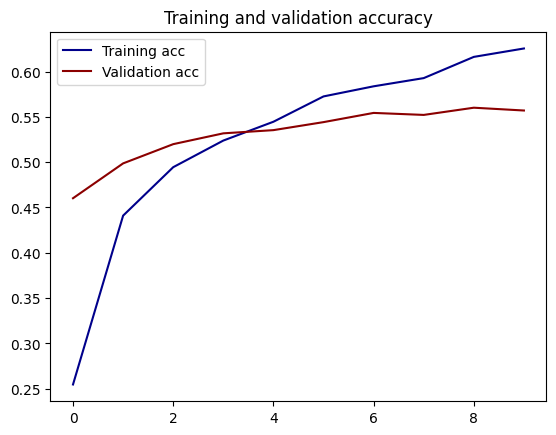

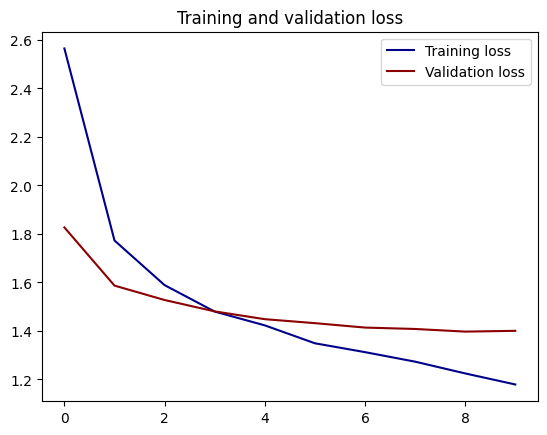

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Training acc', color="darkblue")
plt.plot(epochs, val_acc, label='Validation acc', color="darkred")
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss', color="darkblue")
plt.plot(epochs, val_loss, label='Validation loss', color="darkred")
plt.title('Training and validation loss')
plt.legend()

plt.show()